In [1]:
import matplotlib.pyplot as plt

In [2]:
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE, MDS
from bs4 import BeautifulSoup
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

def preprocess(s):
    s = BeautifulSoup(s, 'html5lib').get_text()
    s = ' '.join(s.split())
    s = s.strip().lower()
    return s

In [3]:
# load and randomize
yelps = pd.read_csv('sentiment/yelps.csv').sample(frac=1.)
movies = pd.read_csv('sentiment/movies.csv').sample(frac=1.)

## Inspecting p(X) of the BOW vectorizers

Assuming that our data consists of discrete features, as in the Bag of Words models we have seen so far, visualizing $p(X)$ consists of visualizing the PMF of a multionomial distribution that consists of all the features in our data. 

Of course, this is a very wide distribution, even if we just include unigrams. 

Thus, we will visualize just the most popular features. 

We will see how, given the most popular features of one dataset, the other dataset compares. 

In [4]:
from copy import deepcopy

def _train_and_transform(vectorizer, X):
    vectorizer.fit(X)
    return vectorizer, vectorizer.transform(X)

def compare(vectorizer, A, B):
    vec_A, VA = _train_and_transform(deepcopy(vectorizer), A) 
    vec_B, VB = _train_and_transform(deepcopy(vectorizer), B) 

    # Get the most popular words for A
    # ignoring the top 25 super common
    # words
    sums = np.array(VA.sum(0)).reshape(-1)
    tops = np.argsort(sums)[-325:-25]
    freqs_A = sums[tops]

    features = np.array(vec_A.get_feature_names())[tops]

    idxs = np.array([vec_B.vocabulary_.get(s) for s in features])
    sums = np.array(VB.sum(0)).reshape(-1)
    freqs_B = [sums[i] if i else 0. for i in idxs]

    return pd.concat([pd.DataFrame({ 'word': features, 'dataset': d, 'freq': f }) 
                      for d,f in [('A',freqs_A), ('B',freqs_B)]])

In [5]:
vectorizer = TfidfVectorizer(preprocessor = preprocess, min_df = 1, use_idf=False)
df = compare(vectorizer, yelps.sample(500).text, movies.sample(500).text)

In [6]:
plt.rcParams['figure.figsize'] = [14, 10]

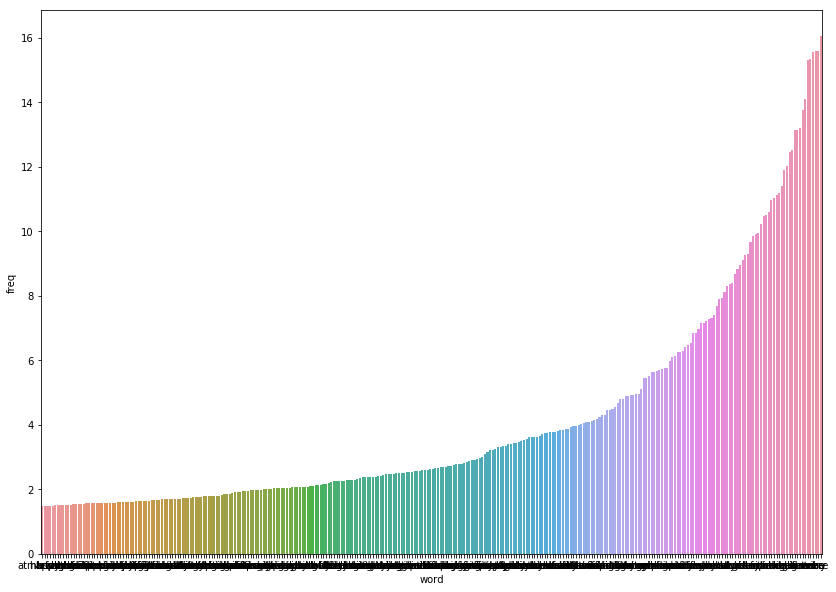

In [7]:
sns.barplot(x = 'word', 
            y = 'freq', 
            data = df[df.dataset == 'A'])

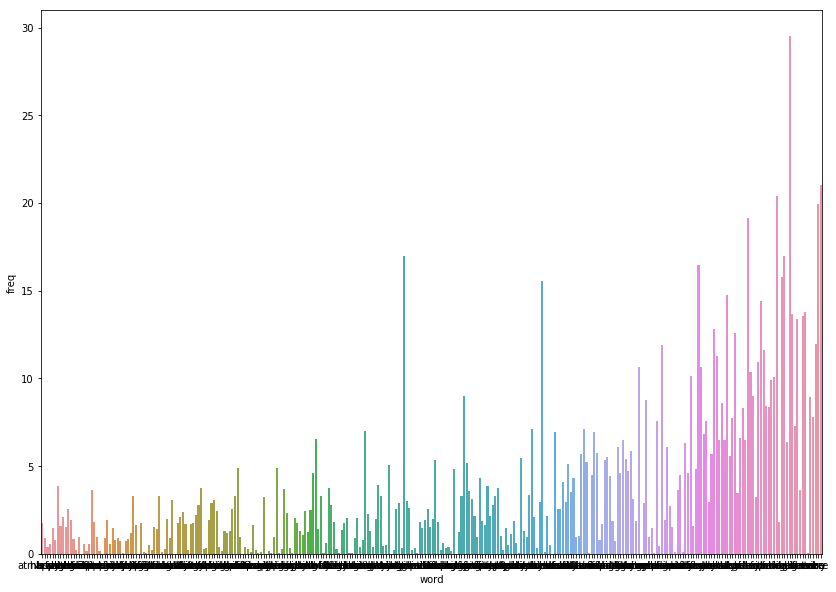

In [8]:
sns.barplot(x = 'word', 
            y = 'freq', 
            data = df[df.dataset == 'B'])

## Generative vs. Discriminative

Play around with the following plotting function. Is this consisten with the theoretical results of Ng and Jordan? Can you get the opposite results? Why? 

/home/kaka/anaconda3/lib/python3.7/site-packages/bs4/__init__.py:273: UserWarning: "b'..'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)
/home/kaka/anaconda3/lib/python3.7/site-packages/bs4/__init__.py:273: UserWarning: "b'..'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)
/home/kaka/anaconda3/lib/python3.7/site-packages/bs4/__init__.py:336: UserWarning: "https://www.consumeraffairs.com/news/mypillow-gets-a-rude-awakening-as-the-better-business-bureau-gives-it-an-f-010517.html" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/home/kaka/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logis

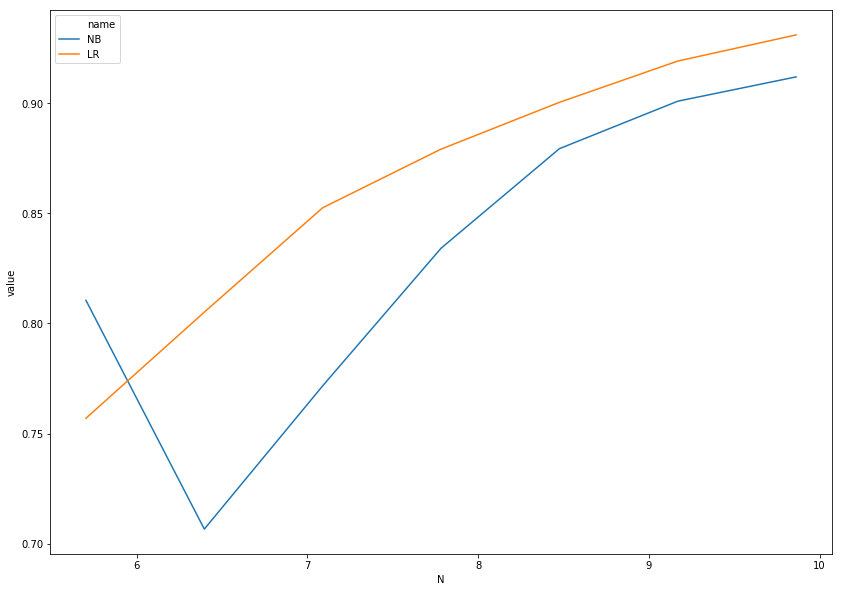

In [9]:
vectorizer = TfidfVectorizer(preprocessor = preprocess, min_df = 20, use_idf=False)
V = vectorizer.fit_transform(yelps.text)
y = yelps.positive

def _cv_score(V, y, models):
    return [{ 'name': name, 'value': np.mean(cross_val_score(model, V, y, cv=3)) }
            for name, model in models]

def plot_cv_scores(V, y, models, ticks):
    scores = [_cv_score(V[:t], y[:t], models) for t in ticks]        
    scores = [({'N': np.log(t) , **i}) for t,s 
              in zip(ticks, scores) for i in s]
    df = pd.DataFrame(scores)
    return sns.lineplot(y='value', x='N', hue='name', data=df)

models = [('NB', MultinomialNB(fit_prior=False)), 
          ('LR', LogisticRegression())]

plot_cv_scores(V, y, models, [300, 600, 1200, 2400, 4800, 9600, 19200])

## Searching the Grid

Hyperparameter tuning, in its simplest form, can be done via a grid search. 

We can use cross validation to estimate the out-of-sample expected risk. 

SKlearn gives us a very nice package for this: GridSearchCV

The API can be a bit complicated at first glance, but it's simple once you get used to it and comfortable with the idea of a "pipeline". 

In [10]:
from sklearn import metrics, svm
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

In [14]:
# Perform this on a smaller sample of the data to not break your machine
yelps = yelps.sample(10000)
movies = movies.sample(10000)

### 1. Logistic Regression

In [11]:
# Create logistic regression
logistic = LogisticRegression()

In [12]:
# Create regularization penalty space
penalty = ['l1', 'l2']

# Create regularization hyperparameter space
C = [0.001, 0.01, 0.1, 1, 10, 100, 1000]

# Create hyperparameter options
hyperparameters = dict(C=C, penalty=penalty)

In [13]:
# Create grid search using 5-fold cross validation
clf_log = GridSearchCV(logistic, hyperparameters, cv=5, verbose=0)

In [15]:
vectorizer = TfidfVectorizer(preprocessor = preprocess, min_df = 20, use_idf=False)
V_yelps = vectorizer.fit_transform(yelps.text)
y_yelps = yelps.positive

/home/kaka/anaconda3/lib/python3.7/site-packages/bs4/__init__.py:273: UserWarning: "b'..'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)


In [16]:
# Fit grid search
best_model_log = clf_log.fit(V_yelps, y_yelps)

/home/kaka/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [17]:
# View the accuracy score
print('Best score for training:', best_model_log.best_score_) 

# View best hyperparameters
print('Best Penalty:', best_model_log.best_estimator_.get_params()['penalty'])
print('Best C:', best_model_log.best_estimator_.get_params()['C'])

Best Penalty: l2
Best C: 10


### 2. Support Vector Machine

In [18]:
parameter_candidates = [
  {'C': [1, 10, 100, 1000], 'kernel': ['linear']},
  {'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001], 'kernel': ['rbf']},
]

In [19]:
# Create a classifier object with the classifier and parameter candidates
clf_svm = GridSearchCV(estimator=svm.SVC(), param_grid=parameter_candidates, n_jobs=-1)

# Train the classifier on data's feature and target data
best_model_svm = clf_svm.fit(V_yelps, y_yelps)

/home/kaka/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


In [20]:
# View the accuracy score
print('Best score for training:', best_model_svm.best_score_) 

# View the best parameters for the model found using grid search
print('Best C:', best_model_svm.best_estimator_.C) 
print('Best Kernel:', best_model_svm.best_estimator_.kernel)
print('Best Gamma:', best_model_svm.best_estimator_.gamma)

Best score for training: 0.9425
Best C: 1000
Best Kernel: rbf
Best Gamma: 0.001


## Crosstraining

Test how well your model, when trained on one dataset, performs on the other. 

To do this, make sure that you: 

1. You perform the "fitting" of both the vectorizer and the model on one of the sets
2. Use the "transform" of the vectorizer to transform the second dataset into the same feature space (X) that your model was trained on. 
3. Use the "predict" of your model to see how well it did on the second dataset. 

How well does your model generalize from one to the other? What does this say about "sentiment"? 

In [21]:
V_movies = vectorizer.transform(movies.text)
y_movies = movies.positive

### 1. Logistic Regression

In [22]:
# Predict target vector
pred_log = best_model_log.predict(V_movies)

score_log = metrics.accuracy_score(y_movies,pred_log)
print('Logistic Regression Score:', score_log)

Logistic Regression Score: 0.7726


In [27]:
# Construct the confusion matrix
data_log = {'y_Predicted': pred_log,
        'y_Actual': y_movies
        }
df_log = pd.DataFrame(data_log, columns=['y_Actual','y_Predicted'])
confusion_matrix_log = pd.crosstab(df_log['y_Actual'], df_log['y_Predicted'], rownames=['Actual'], colnames=['Predicted'])

print(confusion_matrix_log)

Predicted  False  True 
Actual                 
False       3737   1327
True         947   3989


### 2. Support Vector Machine

In [23]:
# Predict target vector
pred_svm = best_model_svm.predict(V_movies)

score_svm = metrics.accuracy_score(y_movies,pred_svm)
print('SVM Score:', score_svm)

SVM Score: 0.7702


In [26]:
# Construct the confusion matrix
data_svm = {'y_Predicted': pred_svm,
        'y_Actual': y_movies
        }
df_svm = pd.DataFrame(data_svm, columns=['y_Actual','y_Predicted'])
confusion_matrix_svm = pd.crosstab(df_svm['y_Actual'], df_svm['y_Predicted'], rownames=['Actual'], colnames=['Predicted'])

print(confusion_matrix_svm)

Predicted  False  True 
Actual                 
False       3758   1306
True         992   3944


## Results

We have done the prediction with two different classifiers, both Discriminative.

With Logistic Regression, we managed to predict correctly the sentiments in the 'movies' dataset 77.26% of the time. With Support Vector Machine we scored a bit lower, a 77.02%.

Then, constructing the confusion matrix for both model predictions, we observe that:  
- We predict more accurately the Positive sentiments than the Negative sentiments
- The Recall or Sensitivity (Actual Positive sentiments predicted Positive) is around 80%
- The Specificity (Actual Negative sentiments predicted Negative) is around 74%